In [11]:
import pandas as pd
import random
import numpy as np
from datetime import datetime as dt
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, Imputer
from sklearn.metrics import mean_squared_error as mse, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree as te
from sklearn.externals.six import StringIO  
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import pydot 

# 1. IMPORT DATA

### Write wanted sample, max 70 000, set 0 if all data wanted:

In [12]:
sample_dataset = 0

In [13]:
########################################## loading data ##########################################


print("Making sample data")
# TAKE A SAMPLE OF DATA
filename = "user_data_public.csv"

if sample_dataset != 0:
    n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    s = sample_dataset #desired sample size
    skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
    df_master = pd.read_csv(filename, 
                            skiprows=skip, 
                            dtype = object)
else:
    df_master = pd.read_csv(filename, dtype = object)
print("Finished making sample data")

data = df_master.copy()

questions  = pd.read_csv('question_data.csv',sep = ';')
df_q_list = pd.read_csv('question_data.csv',sep = ';', index_col=0)

Making sample data
Finished making sample data


# 2. Descriptive

C:\Users\karl_\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\karl_\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\karl_\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\karl_\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a

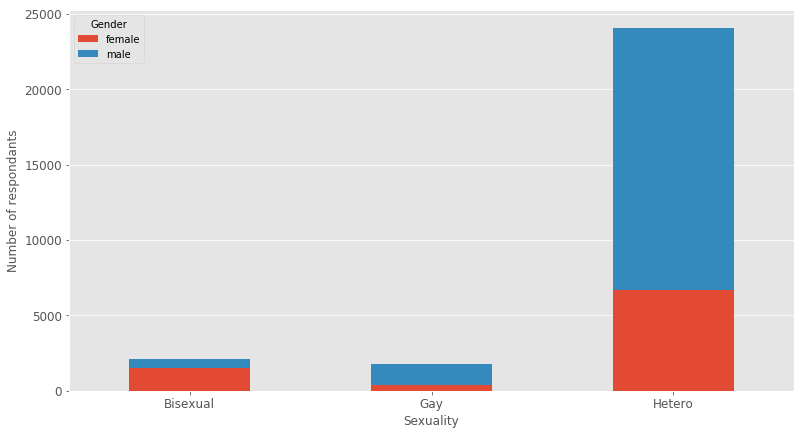

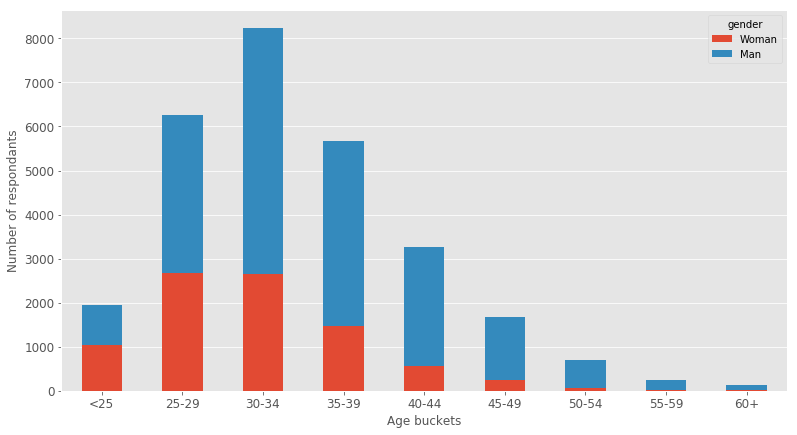

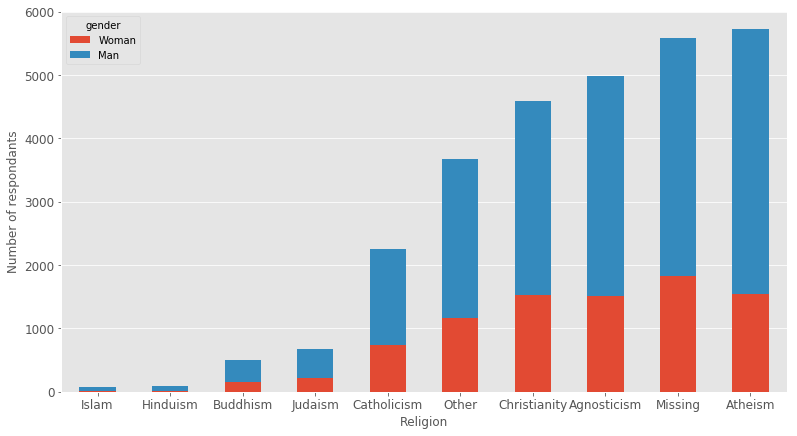

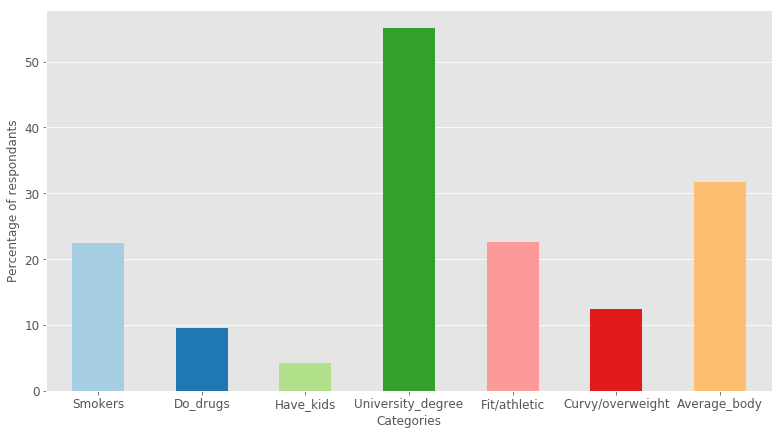

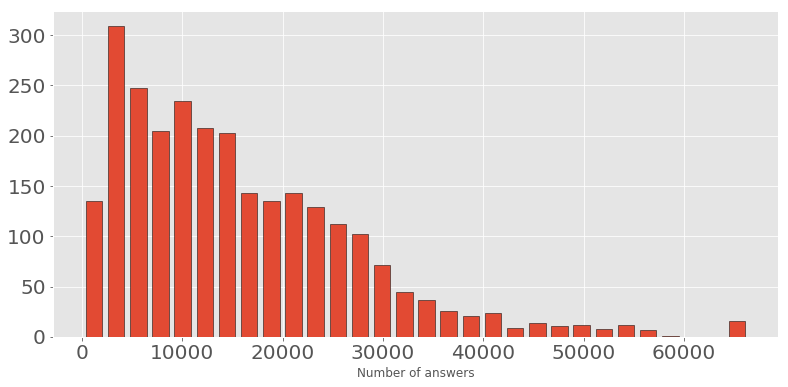

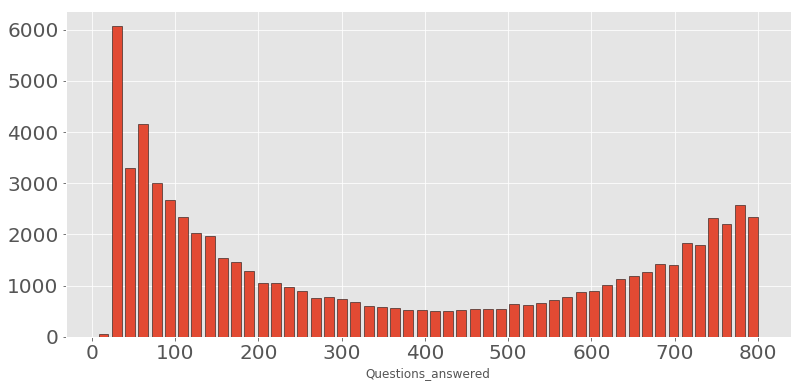

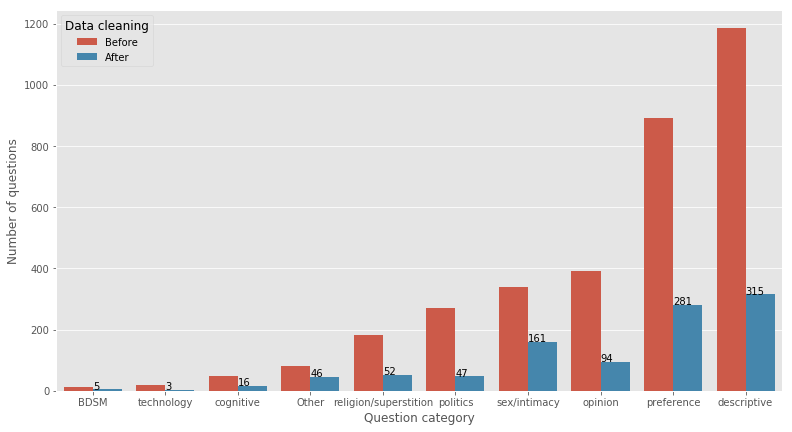

In [14]:
########################################## Manipulating data ##########################################

data["Questions_answered"] = pd.notnull(data).sum(axis = 1)
data["gender"] = data["gender"].fillna(value = "Other")
data["gender"].unique()

table1 =pd.DataFrame({'Sex':[],'Observations':[],'Straight_ratio':[],'Avg questions answered':[],'Religious':[]})


questions["Keywords"] = questions["Keywords"].fillna(value = "Other")
questions_banned = list(questions.loc[questions.loc[:,"N"] <= 20000,"Unnamed: 0"])
questions_less = questions.loc[questions.loc[:,"N"] > 20000,:].reset_index()

data_reduced = data.drop(questions_banned, axis = 1)
data_reduced["Questions_answered"] = pd.notnull(data_reduced).sum(axis = 1)
questions_answered_reduced = data_reduced["Questions_answered"]
data_reduced = data_reduced.loc[data_reduced.loc[:,"Questions_answered"] >= 400,:]
data_reduced = data_reduced.reset_index().drop(["index"],axis = 1)

# Creating data for questions graph

categories = ['sex/intimacy','cognitive','descriptive','BDSM','preference',
              'opinion','technology','politics','religion/superstition', 'Other']
groups = {'Category': categories,'Value':[0]*len(categories)}

groups_df1 = pd.DataFrame(data = groups)
for i in range(0,len(questions["Keywords"])) :
    tags = questions["Keywords"][i].split(';')
    for j in range(0,len(tags)) :
        groups_df1.loc[groups_df1.loc[:,"Category"] == tags[j].strip(),"Value"] = groups_df1.loc[groups_df1.loc[:,"Category"] == tags[j].strip(),"Value"] + 1
groups_df1 = groups_df1.sort_values(by = "Value").reset_index().drop(["index"],axis = 1)


groups_df2 = pd.DataFrame(data = groups)
for i in range(0,len(questions_less["Keywords"])) :
    tags = questions_less["Keywords"][i].split(';')
    for j in range(0,len(tags)) :
        groups_df2.loc[groups_df2.loc[:,"Category"] == tags[j].strip(),"Value"] = groups_df2.loc[groups_df2.loc[:,"Category"] == tags[j].strip(),"Value"] + 1
groups_df2 = groups_df2.sort_values(by = "Category").reset_index().drop(["index"],axis = 1)

    
groups_df1["Data cleaning"] = "Before"
groups_df2["Data cleaning"] = "After"

groups = groups_df1.append(groups_df2)

groups['Category'] = pd.Categorical(groups['Category'], ['BDSM','technology', 'cognitive','Other',
                     'religion/superstition','politics','sex/intimacy','opinion','preference',
                     'descriptive'])
groups_df2['Category'] = pd.Categorical(groups_df2['Category'], ['BDSM','technology', 'cognitive','Other',
                     'religion/superstition','politics','sex/intimacy','opinion','preference',
                     'descriptive'])
    
groups = groups.sort_values(['Category','Data cleaning'], ascending=[1,0]).reset_index().drop(["index"],axis = 1)
groups_df2 = groups_df2.sort_values(['Category','Data cleaning'], ascending=[1,0]).reset_index().drop(["index"],axis = 1)
    
### prepping data for stacked columns chart

# prepping gender orientation
gender_orientation = data_reduced["gender_orientation"].value_counts()
gender_orientation = pd.DataFrame(data = {'Gender_orientation':list(gender_orientation.index),'Value':list(gender_orientation),'Gender':['empty'] *len(gender_orientation),'Orientation':['empty']*len(gender_orientation)})
for i in range(0,len(gender_orientation)):
    tags = gender_orientation['Gender_orientation'][i].split('_')
    gender_orientation["Orientation"][i] = tags[0] 
    gender_orientation["Gender"][i] = tags[1]
gender_orientation = gender_orientation.pivot(index = 'Orientation',columns = 'Gender', values = 'Value')

plt.style.use(u'ggplot')
fig = gender_orientation.loc[:,['female','male']].plot.bar(stacked=True,grid = False, figsize=(13,7),
                            #title = 'Distribution of sexuality across gender',
                            fontsize = 12,rot = 0)
fig.set(xlabel='Sexuality', ylabel='Number of respondants')
fig = fig.get_figure()
fig.gca().yaxis.grid(True)
fig.savefig("Orientation.png")

# Prepping age and gender
age = data_reduced.loc[~data_reduced["d_age"].isnull(),:].reset_index()
age = age[["d_age","gender"]]
age["Age_bucket"] = ['empty'] * len(age["d_age"])
age = age.convert_objects(convert_numeric=True)
age.loc[age["d_age"] < 25,"Age_bucket"] = "24 or less"
age.loc[(age["d_age"] >= 25) & (age["d_age"] <= 29),"Age_bucket"] = "25-29"
age.loc[(age["d_age"] >= 30) & (age["d_age"] <= 34),"Age_bucket"] = "30-34"
age.loc[(age["d_age"] >= 35) & (age["d_age"] <= 39),"Age_bucket"] = "35-39"
age.loc[(age["d_age"] >= 40) & (age["d_age"] <= 44),"Age_bucket"] = "40-44"
age.loc[(age["d_age"] >= 45) & (age["d_age"] <= 49),"Age_bucket"] = "45-49"
age.loc[(age["d_age"] >= 50) & (age["d_age"] <= 54),"Age_bucket"] = "50-54"
age.loc[(age["d_age"] >= 55) & (age["d_age"] <= 59),"Age_bucket"] = "55-59"
age.loc[age["d_age"] >= 60,"Age_bucket"] = "60+"
age = age.groupby(['gender','Age_bucket'], as_index=False).agg({'d_age':'count'})
age = age.pivot(index = 'Age_bucket',columns = 'gender', values = 'd_age')
age = age.fillna(value = 0)
age.rename(index={"24 or less":"<25"},inplace = True) 

fig = age.loc[:,['Woman','Man']].plot(kind = 'bar',grid = False,stacked=True, figsize=(13,7),
             #title = 'Distribution of age across gender',
             fontsize = 12,rot = 0)
fig.set(xlabel='Age buckets', ylabel='Number of respondants')
fig = fig.get_figure()
fig.gca().yaxis.grid(True)
fig.savefig("Age.png")
    
# Prepping data for religion
religion = data_reduced[['d_religion_type','gender']]
religion.loc[data_reduced["d_religion_type"] == '-','d_religion_type'] = 'Missing'
religion['Value'] = [1] * len(religion['gender'])
religion = religion.groupby(['gender','d_religion_type'], as_index=False).agg({'Value':'count'})
religion = religion.pivot(index = 'd_religion_type',columns = 'gender', values = 'Value').fillna(value = 0)
religion['Total'] = religion['Man'] + religion['Woman'] + religion['Other']
religion = religion.sort_values(by = "Total")

fig = religion.loc[:,['Woman','Man']].plot(kind = 'bar',grid = False,stacked=True, figsize=(13,7),
             fontsize = 12,rot = 0)
fig.set(xlabel='Religion', ylabel='Number of respondants')
fig = fig.get_figure()
fig.gca().yaxis.grid(True)
fig.savefig("Religion.png")

data_reduced.loc[(data_reduced["d_religion_type"] != "Agnosticism") & (data_reduced["d_religion_type"] != "Atheism") & (data_reduced["gender"] == "Woman") ,"q41"].value_counts()
data_reduced.loc[(data_reduced["d_religion_type"] != "Agnosticism") & (data_reduced["d_religion_type"] != "Atheism") & (data_reduced["gender"] == "Man") ,"q41"].value_counts()

# Prepping random data
random = data_reduced[['gender','d_smokes','d_drugs','d_offspring_current',"d_education_type","d_bodytype",]]

ra = pd.DataFrame({'Categories':['Smokers','Do_drugs','Have_kids','University_degree','Fit/athletic','Curvy/overweight','Average_body'],
      'Value':[random.loc[data_reduced["d_smokes"] != "No",'d_smokes'].value_counts().sum()/len(random[["gender"]])*100,
               random.loc[data_reduced["d_drugs"] != "Never",'d_drugs'].value_counts().sum()/len(random[["gender"]])*100,
               random.loc[data_reduced["d_offspring_current"] == "kids",'d_offspring_current'].value_counts().sum()/len(random[["gender"]])*100,
               random.loc[(data_reduced["d_education_type"] == "university") | (data_reduced["d_education_type"] == "masters program"),'d_education_type'].value_counts().sum()/len(random[["gender"]])*100,
               random.loc[(data_reduced["d_bodytype"] == "Fit") | (data_reduced["d_bodytype"] == "Athletic"),'d_bodytype'].value_counts().sum()/len(random[["gender"]])*100,
               random.loc[(data_reduced["d_bodytype"] == "Curvy") | (data_reduced["d_bodytype"] == "Overweight"),'d_bodytype'].value_counts().sum()/len(random[["gender"]])*100,
               random.loc[data_reduced["d_bodytype"] == "Average",'d_bodytype'].value_counts().sum()/len(random[["gender"]])*100
               ]})
ra = ra.set_index(ra["Categories"],'Categories') 
    
fig = ra.plot(kind = 'bar',grid = False, legend = False, figsize=(13,7),
             fontsize = 12,rot = 0,color=[plt.cm.Paired(np.arange(len(ra)))])
fig.set(xlabel='Categories', ylabel='Percentage of respondants')
fig = fig.get_figure()
fig.gca().yaxis.grid(True)
fig.savefig("Random.png")
 
# Deleting unused variables
del  tags, i,j,categories,questions_banned

########################################## more graphs ##########################################


fig, ax = plt.subplots(figsize=(13,6), ncols=1, nrows=1)
plt.style.use(u'ggplot')
h_num_answered_question = sns.distplot(questions["N"], kde = False, bins = 30,axlabel = "Number of answers",
                                       hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0}).tick_params(labelsize=20)
fig.savefig("Figure1a.png")

fig, ax = plt.subplots(figsize=(13,6), ncols=1, nrows=1)
h_questions_answered = sns.distplot(questions_answered_reduced, kde = False, bins = 50,#axlabel = "Number of questions answered",
                                    hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0}).tick_params(labelsize=20)                                
fig.savefig("Figure1b.png")

fig, ax = plt.subplots(figsize=(13,7), ncols=1, nrows=1,)
h_question_categories=sns.barplot(x='Category',y='Value',hue = "Data cleaning",data=groups)
h_question_categories.set(xlabel='Question category', ylabel='Number of questions')
for index, row in groups_df2.iterrows():
    h_question_categories.text(row.name,row.Value, row.Value)
fig.savefig("Questions.png")


# 3. Structuring for Machine Learning


In [15]:
#IMPORTANT : THIS IS IN EXCEL FORMAT, CHANGE TO CSV IF YOUR FILE IS NOT XLSX
#df_q_list = pd.read_excel("question_data.xlsx")


# Take only questions with n answers and put the questions in a column
n_answers = 20000
df_keep = pd.DataFrame()
df_keep['keep_questions'] = df_q_list[df_q_list["N"]>n_answers].index

#Keep only questions that are also in master dataframe and make new dataframe with most answered questions
df_keep = df_keep[df_keep["keep_questions"].isin(list(df_master.columns.values))]
df_master_keep = df_master[list(df_keep["keep_questions"])]

#Count not missing each row i.e: number of answered questions by each preson:
df_master_keep["answered_questions"] = df_master_keep.notnull().sum(axis=1).copy()

#Choose only rows with at least n answered questions
n_questions = 400
df_clean_v1 = df_master_keep[df_master_keep["answered_questions"]>n_questions]

#Create dummy for sexual orientation, where 1 = NOT STRAIGHT
print("Now creating Dummy of sexual orientation")
sexual_orientation = []
for x in df_clean_v1['d_orientation']:
    if pd.isnull(x):
        sexual_orientation.append(1) #Since we have persons answered over a 1000 questions, so if they have not answered their sexual orientation we assume they are either uncertain or dont want to disclose because of fear of persecution/judgement from peers
    elif x != "Straight":
        sexual_orientation.append(1)
    else:
        sexual_orientation.append(0)
        
#Turn it into a dataframe and put labels from dataframe on
y = pd.DataFrame(sexual_orientation, index = df_clean_v1.index)

# Drop sexual orientation from master dataframe
df_clean_v1.drop(columns = ["d_orientation"], inplace = True)
print("finished")

C:\Users\karl_\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Now creating Dummy of sexual orientation
finished


C:\Users\karl_\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
#Remove the most problematic questions, and them make all of the categorical variables dummiew
df_prep = df_clean_v1.drop(columns = ["q1401", "q80928", "q546", "q1040", "q35203", "q6258", "lf_want"
                                      #Not so obvious:
                                      #, "p_sprit", "p_trusting","p_sloppy","p_adven", "lf_single", "q1128"
                                     ])
df_dummy = pd.get_dummies(df_prep, dummy_na = False) #When missing giver 0 to all dummies created for the quesion with the missing value
#df_dummy.fillna(value = -1, inplace = True) #If missing insert -1 # This code does not work
X = df_dummy

#INSERT MISSING VALUES BACK INTO THE DUMMIES FOR LATER IMPUTER
for i in list(df_keep["keep_questions"].head()):
    X.loc[df_prep[i].isnull(), X.columns.str.startswith(i+"_")] = np.nan
    
print("Structuring complete")

Structuring complete


### We make a sample where 80pct. of the data is used for development, and the number of kfolds to be used and type of imputer to replace the missing values

In [17]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

kfolds = KFold(n_splits=10)

# Missing in the dummies will be set to the mean of the answers by default
im = Imputer()

# Unsupervised Learning

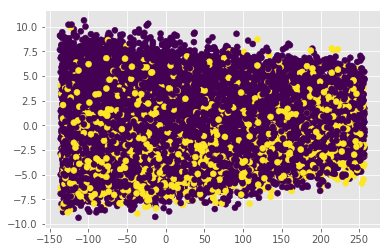

<Figure size 432x288 with 0 Axes>

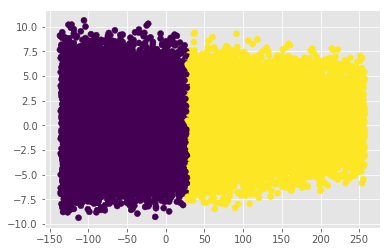

<Figure size 432x288 with 0 Axes>

In [18]:
# Unsupervised Learning

## Using K-Means to split data into two clusters

# UNSUPERVISED LEARNING CLUSTERS:

X_u = pd.DataFrame(im.fit_transform(X), index = X.index)

# create kmeans object
kmeans = MiniBatchKMeans(n_clusters=2, random_state=1)

# print location of clusters learned by kmeans object
#print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = pd.DataFrame(kmeans.fit_predict(X_u), index = y.index) 
accuracy_score(y,y_km)

#Make into DF for add column
df_X = pd.DataFrame(X_u, index = df_clean_v1.index).copy()
df_X["unsupervised"] = y_km

## Visualisation of unsupervised learning

# We use the PCA to create the first scatterplot, which shows the distribution of "not straight" in the actual data

plt.style.use('ggplot')

pca_2d = PCA(n_components=2).fit_transform(X_u)

fig1, ax = plt.subplots(1,1)

#Here we make a reference plot to see whether there is a big difference between the actual classes and the predicted
plt.figure('Reference Plot')
ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c = y.values.ravel())

fig1.savefig('sample_cluster1.png', bbox_inches='tight')

fig2, ax = plt.subplots(1,1)

#Then, we plot the K-Mean clusters that are trying to predict the categories.
plt.figure('K-means with 2 clusters')
ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c = kmeans.labels_)

fig2.savefig('sample_cluster2.png', bbox_inches='tight')

In [19]:
#X["cluster_group"] = y_km # This extra column is not used, as it does not give any extra accuracy to the models

# Decision Tree

In [20]:
accuracy = []
start = dt.now()
range_tree = range(1,11)
for x in range_tree:
    tree = DecisionTreeClassifier(criterion="gini", max_depth= x, random_state=1)  
    accuracy_ = []
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):

        X_train, y_train, = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 

        X_train = pd.DataFrame(im.fit_transform(X_train),index = X_train.index)
        X_val = pd.DataFrame(im.transform(X_val), index = X_val.index)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_val)
        accuracy_.append(accuracy_score(y_val, y_pred))
    print("This was the "+str(x)+" iteration", (dt.now() - start).total_seconds())
    accuracy.append(accuracy_)
temp_t = pd.DataFrame(accuracy).mean(axis=1)
temp_t.index = range_tree
optimal_t = temp_t.nlargest(1)
print("Time:", (dt.now() - start).total_seconds())
print("Optimal hyperparameter: "+ str(optimal_t.index[0]) + " with accuracy: " + str(optimal_t.values) )

This was the 1 iteration 74.615361
This was the 2 iteration 155.996086
This was the 3 iteration 245.398755
This was the 4 iteration 341.878725
This was the 5 iteration 445.379669
This was the 6 iteration 556.02687
This was the 7 iteration 674.427551
This was the 8 iteration 800.382746
This was the 9 iteration 935.406631
This was the 10 iteration 1076.146336
Time: 1076.15036
Optimal hyperparameter: 6 with accuracy: [0.8766041]


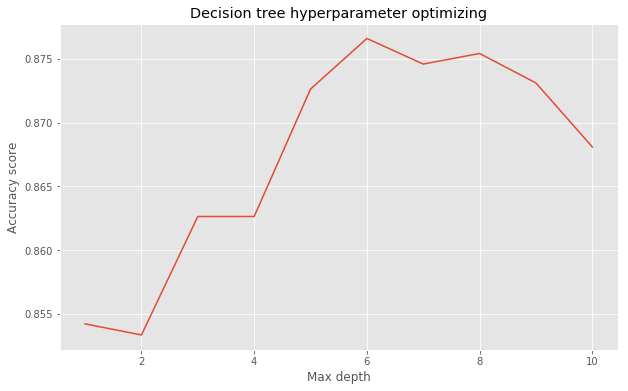

In [21]:
temp_t.plot(figsize=(10, 6))
plt.title("Decision tree hyperparameter optimizing")
plt.ylabel('Accuracy score')
plt.xlabel('Max depth')
plt.style.use('ggplot')
plt.savefig('decisiong_tree_depth_2.png')

In [22]:
tree = DecisionTreeClassifier(criterion='gini', max_depth= optimal_t.index[0], random_state=1)

X_dev = pd.DataFrame(im.fit_transform(X_dev), index= X_dev.index)
X_test = pd.DataFrame(im.transform(X_test), index= X_test.index)


tree.fit(X_dev, y_dev)
predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, predict))
print()
print(confusion_matrix(y_test,predict))

0.8772695530726257

[[4651  140]
 [ 563  374]]


### This prints the decision tree

In [23]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
classe_names = tree.classes_
dot_data = StringIO() 
te.export_graphviz(tree, out_file=dot_data, 
                   feature_names = list(X.columns.values), 
                   class_names= ["Straight", "Not Straight"]
                  ) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

graph[0].write_pdf("print_tree.pdf")

# FOREST

In [24]:
accuracy = []
start = dt.now()
range_forest = range(9,16)
for x in range_forest:
    forest = RandomForestClassifier(criterion="gini", max_depth= x, random_state=1)  
    accuracy_ = []
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):

        X_train, y_train, = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        
        X_train = pd.DataFrame(im.fit_transform(X_train),index = X_train.index)
        X_val = pd.DataFrame(im.transform(X_val), index = X_val.index)
        forest.fit(X_train, y_train.values.ravel())
        y_pred = forest.predict(X_val)
        accuracy_.append(accuracy_score(y_val, y_pred))
    print("This was the "+str(x)+" iteration", (dt.now() - start).total_seconds())
    accuracy.append(accuracy_)
temp_f = pd.DataFrame(accuracy).mean(axis=1)
temp_f.index = range_forest
optimal_f = temp_f.nlargest(1)
print("Time:", (dt.now() - start).total_seconds())
print("Optimal hyperparameter: "+ str(optimal_f.index[0]) + " with accuracy: " + str(optimal_f.values) )

This was the 9 iteration 56.003458
This was the 10 iteration 112.959639
This was the 11 iteration 171.001246
This was the 12 iteration 229.94942
This was the 13 iteration 289.859188
This was the 14 iteration 350.849945
This was the 15 iteration 412.848761
Time: 412.856821
Optimal hyperparameter: 14 with accuracy: [0.85469227]


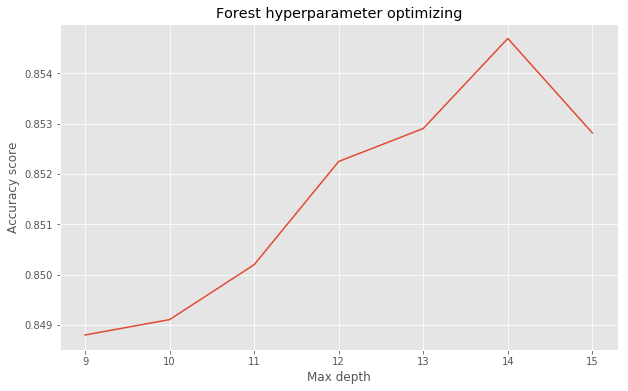

In [25]:
temp_f.plot(figsize=(10, 6))
plt.title("Forest hyperparameter optimizing")
plt.ylabel('Accuracy score')
plt.xlabel('Max depth')
plt.savefig('forest_depth_2.png')

In [26]:
forest = RandomForestClassifier(criterion='gini', max_depth= optimal_f.index[0], random_state=1)

X_dev = pd.DataFrame(im.fit_transform(X_dev), index= X_dev.index)
X_test = pd.DataFrame(im.transform(X_test), index= X_test.index)


forest.fit(X_dev, y_dev.values.ravel())
predict = pd.DataFrame(forest.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, predict))
print()
print(confusion_matrix(y_test,predict))

0.8627793296089385

[[4770   21]
 [ 765  172]]


# LOGIT

In [ ]:
accuracy= []
c_parameter = np.linspace(0.01,0.15,10)
for c_param in c_parameter:
    logit_pipe = make_pipeline(LogisticRegression(random_state= 1, C = c_param)) 
    accuracy_ = []
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train, = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        
        X_train = pd.DataFrame(im.fit_transform(X_train),index = X_train.index)
        X_val = pd.DataFrame(im.transform(X_val), index = X_val.index)

        logit_pipe.fit(X_train, y_train.values.ravel())
        y_pred = logit_pipe.predict(X_val)
        accuracy_.append(accuracy_score(y_val, y_pred))
    print("This was the "+str(c_param)+" iteration", (dt.now() - start).total_seconds())
    accuracy.append(accuracy_)
temp_l = pd.DataFrame(accuracy).mean(axis=1)
temp_l.index = c_parameter
optimal_l = temp_l.nlargest(1)
print("Time:", (dt.now() - start).total_seconds())
print("Optimal hyperparameter: "+ str(optimal_l.index[0]) + " with accuracy: " + str(optimal_l.values) )

This was the 0.01 iteration 514.870442
This was the 0.025555555555555554 iteration 615.481983
This was the 0.041111111111111105 iteration 714.835104
This was the 0.056666666666666664 iteration 818.618916


In [ ]:
temp_l.plot(figsize=(10, 6))
plt.title("Logit hyperparameter optimizing")
plt.ylabel('Accuracy score')
plt.xlabel('Regularization parameter')
plt.savefig('logit_param_2.png')

In [ ]:
logit_pipe = make_pipeline(LogisticRegression(random_state= 1, C = optimal_l.index[0]))


X_dev = pd.DataFrame(im.fit_transform(X_dev), index= X_dev.index)
X_test = pd.DataFrame(im.transform(X_test), index= X_test.index)

logit_pipe.fit(X_dev, y_dev.values.ravel())
predict = pd.DataFrame(logit_pipe.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, predict))
print()
print(print(confusion_matrix(y_test,predict)))